In [5]:
# Importing stuff

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz

warnings.filterwarnings("ignore")

In [6]:
# Read the data files
# Train data

data = pd.read_csv("FinSalesPriceData_train.csv")
data_test = pd.read_csv("FinSalesPriceData_test.csv")


# Competitor's data

comp_price = pd.read_csv("CompetitorPriceData.csv")


In [7]:
missing = data.isnull().sum()
missing

calendar_day                          0
article_id                            0
article_desc                          0
category                              0
subcategory                           0
segment                               0
brand                                 0
brandtype                             0
sell_price                          474
promo_price                     1008363
promo_sales                     1007551
promo_units                           0
gross_profit                          0
scanback                              0
sales_amount                          0
sales_units                           0
cnt_site_art_ranged                   0
cnt_site_art_ranged_pstv_soh          0
tot_soh_ranged_sites                  0
gst_flag                              0
dtype: int64

In [8]:
missing_test = data_test.isnull().sum()
missing_test

calendar_day                         0
article_id                           0
article_desc                         0
category                             0
subcategory                          0
segment                              0
brand                                0
brandtype                            0
sell_price                         230
promo_price                     481893
promo_sales                     481427
promo_units                          0
gross_profit                         0
scanback                             0
sales_amount                         0
sales_units                          0
cnt_site_art_ranged                  0
cnt_site_art_ranged_pstv_soh         0
tot_soh_ranged_sites                 0
gst_flag                             0
dtype: int64

In [9]:
# Feature engineering: 
# promo_save: (sell_price - promo_price)/sell_price x 100%

data['promo_save'] = (data['sell_price']-data['promo_price'])/data['sell_price']
data_test['promo_save'] = (data_test['sell_price']-data_test['promo_price'])/data_test['sell_price']


In [10]:
# Remove prices values that are equal to or lower than 0
for column in ['sell_price', 'promo_price']:
    data = data[data[column].isnull() | (data[column] > 0)].reset_index(drop=True)
    data_test = data_test[data_test[column].isnull() | (data_test[column] > 0)].reset_index(drop=True)

# The following variables can't be less than 0:

for column in ['promo_units', 'promo_sales', 'promo_save', 'scanback', 'sales_amount', 'sales_units', 'cnt_site_art_ranged', 'cnt_site_art_ranged_pstv_soh', 'tot_soh_ranged_sites', 'gross_profit']:
    # print (data[column].min())
    data = data[data[column].isnull() | (data[column] >= 0)].reset_index(drop=True)
    data_test = data_test[data_test[column].isnull() | (data_test[column] >= 0)].reset_index(drop=True)

In [11]:
# Make sure that the numerical variables have the right data type
# Type int

for column in ['promo_units', 'sales_units', 'cnt_site_art_ranged', 'cnt_site_art_ranged_pstv_soh', 'tot_soh_ranged_sites']:
    data[column] = data[column].astype(int)
    data_test[column] = data_test[column].astype(int)

# Type float

for column in ['promo_price', 'sell_price', 'scanback', 'promo_sales', 'sales_amount', 'promo_save', 'gross_profit']:
    data[column] = data[column].astype(float)
    data_test[column] = data_test[column].astype(float)
    
# Type datetime

data['calendar_day'] = pd.to_datetime(data['calendar_day'])
data_test['calendar_day'] = pd.to_datetime(data_test['calendar_day'])

# Convert article_id to string

data['calendar_day'] = pd.to_datetime(data['calendar_day'])
data_test['article_id'] = data_test['article_id'].astype(str)


In [12]:
# Make sure that the categorical variables are strings/boolean

for column in ['article_desc', 'category', 'subcategory', 'segment', 'brand', 'brandtype']:
    data[column] = data[column].astype(str)

mapping = {'Y': True, 'N': False}

data['gst_flag'] = data['gst_flag'].map(mapping)
data

,calendar_day,article_id,article_desc,category,subcategory,segment,brand,brandtype,sell_price,promo_price,...,promo_units,gross_profit,scanback,sales_amount,sales_units,cnt_site_art_ranged,cnt_site_art_ranged_pstv_soh,tot_soh_ranged_sites,gst_flag,promo_save
0,2022-02-07,196544,Skin Control Pimple Patch Micro Dart 9pk,Skin & Sun Care,Skincare Face,Other,SKIN CONTROL,National Brand,13.00,13.00,...,1,86.550,0.00,190.7080,15,176,171,1444,True,0.000000
1,2022-02-07,103515,Spascriptions Superfoods Masks 3x 50ml,Skin & Sun Care,Skincare Face,Masks,SPASCRIPTIONS,National Brand,20.00,NaN,...,0,28.719,0.00,59.7999,3,176,175,1907,True,NaN
2,2022-02-07,103517,Spascriptions Retinol Facial Serum,Skin & Sun Care,Skincare Face,Masks,SPASCRIPTIONS,National Brand,18.00,NaN,...,0,17.158,0.00,35.8198,2,176,174,844,True,NaN
3,2022-02-07,103518,Spascriptions Collagen Facial Serum,Skin & Sun Care,Skincare Face,Masks,SPASCRIPTIONS,National Brand,18.00,NaN,...,0,42.926,0.00,89.6396,5,176,174,938,True,NaN
4,2022-02-07,103520,7th Heaven Blackhead Stardust Face Mask,Skin & Sun Care,Skincare Face,7Th Heaven,7TH HEAVEN,National Brand,6.95,NaN,...,0,16.919,0.00,41.5209,6,176,173,1960,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117251,2023-05-26,201944,Wiggles Toothpaste Strawberry 96g,Personal Hygiene,Oral Care,Toothpaste,PIKSTERS,National Brand,3.50,2.61,...,38,24.585,15.21,99.2115,39,176,172,1358,True,0.254286
1117252,2023-05-26,202203,Wiggles Toothbrush 1pk,Personal Hygiene,Oral Care,Kids,PIKSTERS,National Brand,3.50,2.63,...,37,26.512,14.43,99.8712,38,176,172,1457,True,0.248571
1117253,2023-05-26,202242,Wiggles Toothpaste Vanilla 96g,Personal Hygiene,Oral Care,Kids,PIKSTERS,National Brand,3.50,NaN,...,0,0.000,0.00,0.0000,0,0,0,0,True,NaN
1117254,2023-05-26,202243,Oral B Fresh Clean Toothbrush Med 7pk,Personal Hygiene,Oral Care,Toothbrush,ORAL B,National Brand,10.00,NaN,...,0,38.883,0.00,215.8033,22,176,175,1481,True,NaN


In [13]:
# Column names of the variables with missing values

data_null = data.isnull().sum()
# print(data_null)

missing_df = pd.DataFrame({"Variable": data_null.index, "Missing": data_null.values})
missing_df = missing_df.sort_values(by=["Missing"], ascending= False)
missing_df = missing_df.set_index("Variable")['Missing']
missing_table = missing_df.to_markdown(index=True) # For markdown table, dw about it


print(missing_df)

Variable
promo_save                      959907
promo_price                     959907
promo_sales                     959762
sell_price                         469
category                             0
scanback                             0
gst_flag                             0
tot_soh_ranged_sites                 0
cnt_site_art_ranged_pstv_soh         0
cnt_site_art_ranged                  0
sales_units                          0
sales_amount                         0
gross_profit                         0
subcategory                          0
promo_units                          0
article_id                           0
article_desc                         0
brandtype                            0
brand                                0
segment                              0
calendar_day                         0
Name: Missing, dtype: int64


In [14]:
# Find missing values

# The function below find the price of the functions that sold more than 0 at full price, assuming that if there is a promo price, people would not buy at full price.



def find_missing_price(row):
    if pd.isnull(row['sell_price']):
        if (row['sales_units'] - row['promo_units']) > 0 and not pd.isnull(row['promo_sales']):
            return (row['sales_amount'] - row['promo_sales']) / (row['sales_units'] - row['promo_units'])
        if(row['sales_units'] - row['promo_units']) > 0:
            return (row['sales_amount'] - row['promo_sales']) / (row['sales_units'] - row['promo_units'])
        else:
            return row['sell_price']
    else:
        return row['sell_price']
data['sell_price'] = data.apply(find_missing_price, axis = 1)
data_test['sell_price'] = data_test.apply(find_missing_price, axis = 1)


print(comp_price[comp_price['article_id'] == 659147])

# Search for prices online: 24 dollars for 3 so 8 dollars for 1 (https://www.bigw.com.au/product/dettol-antibacterial-refresh-liquid-hand-wash-refill-950ml-x-3/p/140274)

# Replace prices in the database:
# data['sell_price'] = data['sell_price'].fillna(8)


# There are less value missing in promo_sales than promo_price

def find_missing_promo_price(row):
    if pd.isnull(row['promo_price']):
        if (row['promo_units'] > 0):
            return row['promo_sales'] / row['promo_units']
        else:
            return row['promo_price']
    else:
        return row['promo_price']
def find_missing_promo_sales(row):
    if pd.isnull(row['promo_sales']):
        if (not pd.isnull(row['promo_price']) and not pd.isnull(row['promo_units'])):
            return row['promo_price'] * row['promo_units']
        else:
            return row['promo_sales']
    else:
        return row['promo_sales']
data['promo_price'] = data.apply(find_missing_promo_price, axis = 1)
data['promo_sales'] = data.apply(find_missing_promo_sales, axis = 1)

# Fill in missing promo_save values where possible (not optimised)
data['promo_save'] = (data['sell_price']-data['promo_price'])/data['sell_price']


Empty DataFrame
Columns: [article_id, fiscal_week_start_date, competitor, competitor_shelf_price, competitor_total_price]
Index: []


In [15]:
# In the dictionary, they group Manufacture and National Brand together, I don't know why, but I think that we should group them together in the dataset as well
data['brandtype'] = data['brandtype'].replace({'National Brand': 'Manufacturer/National Brand', 'Manufacturer Brand': 'Manufacturer/National Brand'})
data_test['brandtype'] = data_test['brandtype'].replace({'National Brand': 'Manufacturer/National Brand', 'Manufacturer Brand': 'Manufacturer/National Brand'})


In [16]:
#impute 0 in NA values in promo_sales
data['promo_sales'].fillna(0, inplace=True)
data_test['promo_sales'].fillna(0, inplace=True)

In [17]:
# Replace prices in the database:
data['sell_price'] = data['sell_price'].fillna(8)
data_test['sell_price'] = data_test['sell_price'].fillna(8)

In [18]:
# Fill null values in 'promo_sales' column with values from 'sell_price' column
data['promo_price'] = data['promo_price'].fillna(data['sell_price'])
data_test['promo_price'] = data_test['promo_price'].fillna(data_test['sell_price'])

In [19]:
data['promo_save'] = (data['sell_price']-data['promo_price'])/data['sell_price']
data_test['promo_save'] = (data_test['sell_price']-data_test['promo_price'])/data_test['sell_price']

In [20]:
# Column names of the variables with missing values

data_null = data.isnull().sum()
# print(data_null)

missing_df = pd.DataFrame({"Variable": data_null.index, "Missing": data_null.values})
missing_df = missing_df.sort_values(by=["Missing"], ascending= False)
missing_df = missing_df.set_index("Variable")['Missing']
missing_table = missing_df.to_markdown(index=True) # For markdown table, dw about it


missing_df

Variable
calendar_day                    0
promo_units                     0
gst_flag                        0
tot_soh_ranged_sites            0
cnt_site_art_ranged_pstv_soh    0
cnt_site_art_ranged             0
sales_units                     0
sales_amount                    0
scanback                        0
gross_profit                    0
promo_sales                     0
article_id                      0
promo_price                     0
sell_price                      0
brandtype                       0
brand                           0
segment                         0
subcategory                     0
category                        0
article_desc                    0
promo_save                      0
Name: Missing, dtype: int64

In [21]:
data = data[data['sales_units'] != 0]
data_test = data_test[data_test['sales_units'] != 0]

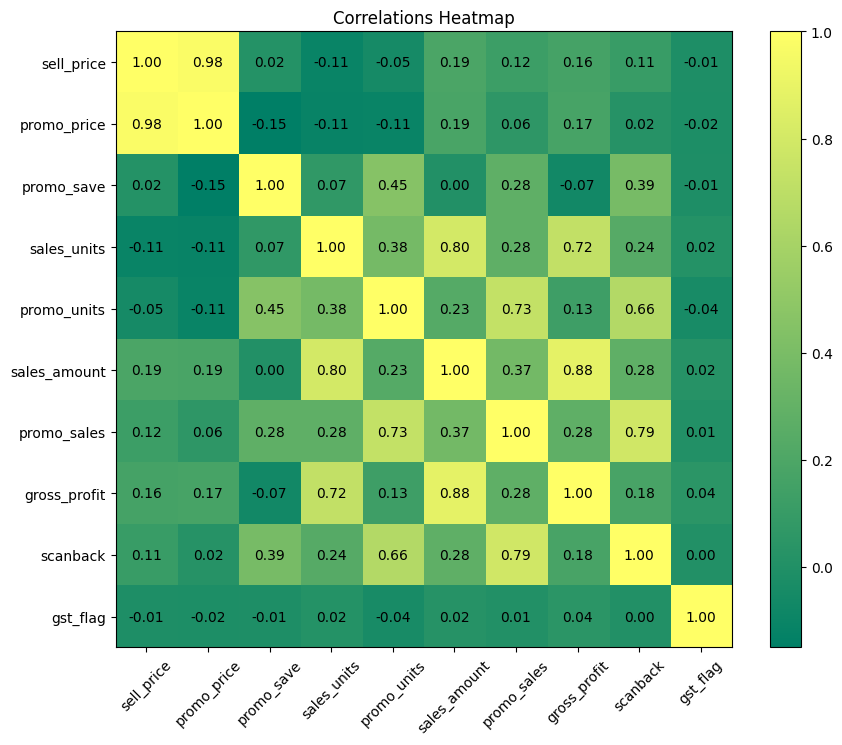

In [22]:
# Correlation heatmap

# data['promo_diff'] = data['sell_price'] - data['promo_price']
train = data[['sell_price', 'promo_price', 'promo_save', 'sales_units', 'promo_units', 'sales_amount', 'promo_sales', 'gross_profit', 'scanback', 'gst_flag']]
c = train.corr()
n_var = len(c)
plt.figure(figsize=(10, 8))
# plt.figure(figsize=(20, 20))
plt.imshow(c, cmap = 'summer')
plt.xticks(range(n_var), c.columns, rotation=45)
plt.yticks(range(n_var), c.columns)

for i in range(n_var):
    for j in range(n_var):
        # text_color = 'white' if abs(c.iloc[i, j]) < 0.5 else 'black'
        # plt.text(i, j, '{:.2f}'.format(c.iloc[i, j]), ha="center", va="center", color=text_color, fontsize = 10)
        # To make it look better in markdown black/white theme, dw about it
        plt.text(i, j, '{:.2f}'.format(c.iloc[i, j]), ha="center", va="center",  fontsize = 10)

# Add colorbar
plt.colorbar()

plt.title('Correlations Heatmap')
plt.show()


In [23]:
# More EDA

# Numerical variables
numeric_cols = data.select_dtypes(include=['int', 'float'])
def human_readable_format(num):
    if num >= 1e6:
        return f'{num/1e6:.2f}M'
    elif num >= 1e3:
        return f'{num/1e3:.2f}K'
    else:
        return f'{num:.2f}'


# print(numeric_cols.describe().applymap(human_readable_format).T.to_markdown())
print(numeric_cols.describe().applymap(human_readable_format).T)


                                count     mean     std     min      25%  \
article_id                    813.25K  675.98K   1.50M  204.00  138.04K   
sell_price                    813.25K    14.17   12.05    1.00     6.50   
promo_price                   813.25K    13.35   11.53    0.00     6.00   
promo_sales                   813.25K    71.20  373.00    0.00     0.00   
promo_units                   813.25K     8.09   29.30    0.00     0.00   
gross_profit                  813.25K    92.53  189.65    0.00    22.76   
scanback                      813.25K    12.61   60.44    0.00     0.00   
sales_amount                  813.25K   348.36  893.31    0.82    71.52   
sales_units                   813.25K    32.82   64.24    1.00     7.00   
cnt_site_art_ranged           813.25K   164.27   39.61    0.00   176.00   
cnt_site_art_ranged_pstv_soh  813.25K   156.57   43.12    0.00   166.00   
tot_soh_ranged_sites          813.25K    1.86K   1.80K    0.00    1.05K   
promo_save               

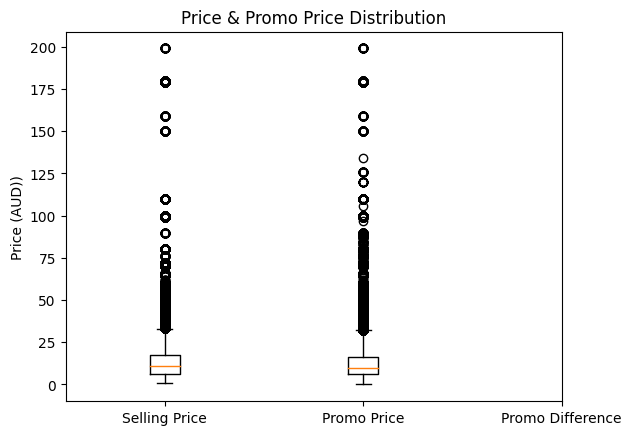

In [24]:
# Boxplots

price_data = [data['sell_price'], data['promo_price'].dropna()]
sales_data = [data['promo_sales'].dropna(), data['sales_amount'], data['gross_profit'], data['scanback']]
units_data = [data['sales_units'], data['promo_units'], data['tot_soh_ranged_sites']]
stock_data = [data['cnt_site_art_ranged'], data['cnt_site_art_ranged_pstv_soh']]
plt.ylabel('Price (AUD))')
plt.title('Price & Promo Price Distribution')
plt.boxplot(price_data)
plt.xticks(range(1, 4), ['Selling Price', 'Promo Price', 'Promo Difference'])
# plt.savefig('PricePromoBox.png')
plt.show()



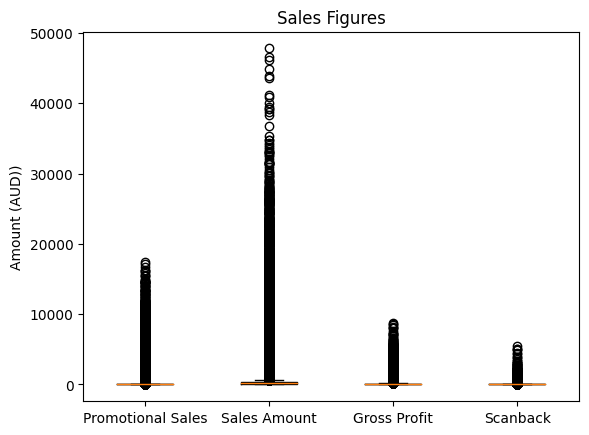

In [25]:
plt.boxplot(sales_data)
plt.ylabel('Amount (AUD))')
plt.title('Sales Figures')
plt.xticks(range(1, 5), ['Promotional Sales', 'Sales Amount', 'Gross Profit', 'Scanback'])
# plt.savefig('SalesBox.png')
plt.show()


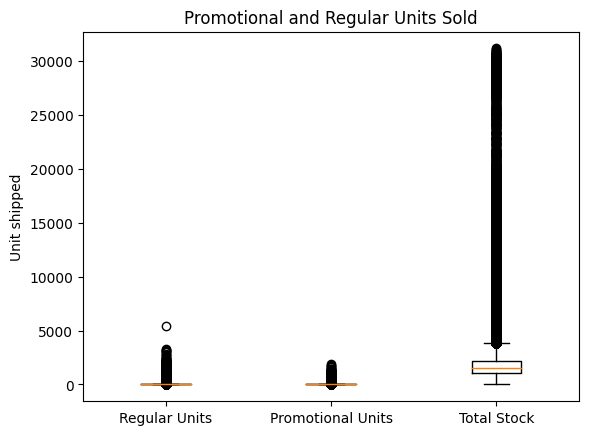

In [26]:
plt.boxplot(units_data)
plt.ylabel('Unit shipped')
plt.title('Promotional and Regular Units Sold')
plt.xticks(range(1, 4), ['Regular Units', 'Promotional Units', 'Total Stock'])
# plt.sevefig('UnitsBox.png')
plt.show()


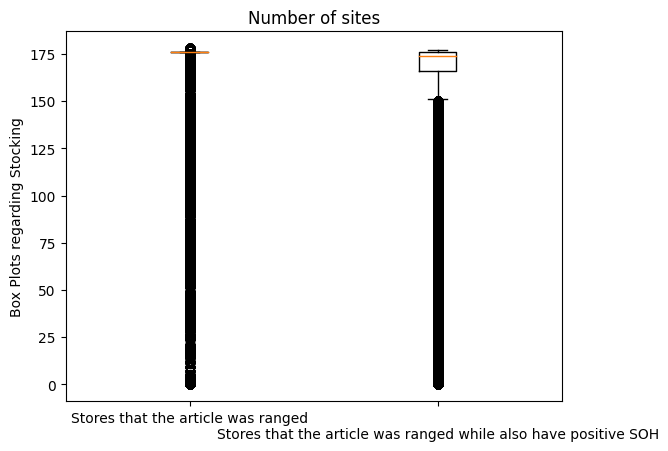

In [27]:
plt.boxplot(stock_data)
plt.ylabel('Box Plots regarding Stocking')
plt.title('Number of sites')
plt.xticks(range(1, 3), ['Stores that the article was ranged', '\nStores that the article was ranged while also have positive SOH'] )
# plt.savefig('StockBox.png')
plt.show()


In [28]:
# Categorical variables

cat_cols = data.select_dtypes(include=['object'])
cat_cols.describe()

,article_desc,category,subcategory,segment,brand,brandtype
count,813247,813247,813247,813247,813247,813247
unique,2488,4,28,134,221,3
top,Skin Control Pimple Patch Micro Dart 9pk,Skin & Sun Care,Skincare Face,Other,NIVEA,Manufacturer/National Brand
freq,471,307287,200128,29343,37622,792226


## Random Forests

In [29]:
drop_columns = ['calendar_day', 'article_desc', 'cnt_site_art_ranged_pstv_soh',
                'gst_flag', 'tot_soh_ranged_sites', 'article_id', 'subcategory', 'segment', 'brand', 
                'sales_amount', 'gross_profit', 'promo_units', 'promo_sales', 'scanback']

data_model = data.drop(columns=drop_columns)
data_model_test = data_test.drop(columns=drop_columns)

# Apply one-hot encoding
data_model = pd.get_dummies(data_model, columns=['category', 'brandtype'])
data_model_test = pd.get_dummies(data_model_test, columns=['category', 'brandtype'])


parameters = {'min_samples_leaf': np.arange(1, 10),
              'max_features': np.arange(1, len(data_model.columns)-1)} # We subtract 1 as it still contains sales:units

random_search = RandomizedSearchCV(RandomForestRegressor(criterion='squared_error', random_state=0), 
                                   parameters, n_iter=20, cv=5, 
                                   scoring='neg_mean_squared_error', random_state=0)
                                   
model = random_search.fit(data_model.drop(columns='sales_units'), data_model['sales_units'])

print(random_search.best_params_)

{'min_samples_leaf': 8, 'max_features': 5}


#### RMSE

In [30]:
predictions = model.predict(data_model_test.drop(columns='sales_units'))
print('RMSE: {:.2f}'.format(mse(data_model_test['sales_units'], predictions, squared=False)))

RMSE: 45.94


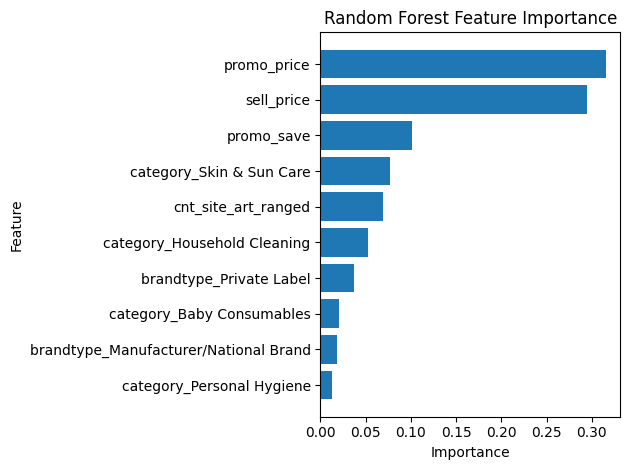

In [31]:
rf = RandomForestRegressor(criterion='squared_error', min_samples_leaf=8, max_features=5, random_state=0)

rf.fit(data_model.drop(columns='sales_units'), data_model['sales_units'])

features = data_model.drop(columns='sales_units').columns
importances = pd.Series(rf.feature_importances_, index=features).sort_values()

plt.barh(range(len(importances[-10:])), importances[-10:], tick_label=importances.index[-10:])
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance'); plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('importances_RF.png')
plt.show()


## Gradient Boosting

In [32]:
data_model_4 = data.drop(columns=drop_columns)
data_model_test_4 = data_test.drop(columns=drop_columns)

# Apply one-hot encoding
data_model_4 = pd.get_dummies(data_model_4)
data_model_test_4 = pd.get_dummies(data_model_test_4)

# Define hyperparameters for RandomizedSearchCV
parameters_4 = {'n_estimators': np.arange(10, 100),
                'learning_rate': np.linspace(0.05, 0.15, 1),
                'max_depth': np.arange(1, 200),
                'subsample': np.linspace(0.5, 1.0, 6)}

# Perform hyperparameter tuning with RandomizedSearchCV
random_search_4 = RandomizedSearchCV(XGBRegressor(objective='reg:squarederror', random_state=0),
                                     parameters_4, n_iter=20, cv=5,
                                     scoring='neg_mean_squared_error', random_state=0)

# Fit the model
model_4 = random_search_4.fit(data_model_4.drop(columns='sales_units'), data_model_4['sales_units'])

# Print the best parameters
print(random_search_4.best_params_)

{'subsample': 0.5, 'n_estimators': 48, 'max_depth': 127, 'learning_rate': 0.05}


#### RMSE

In [33]:
predictions_4 = model_4.predict(data_model_test_4.drop(columns='sales_units'))
print('RMSE: {:.2f}'.format(mse(data_model_test_4['sales_units'], predictions_4, squared=False)))

RMSE: 46.47


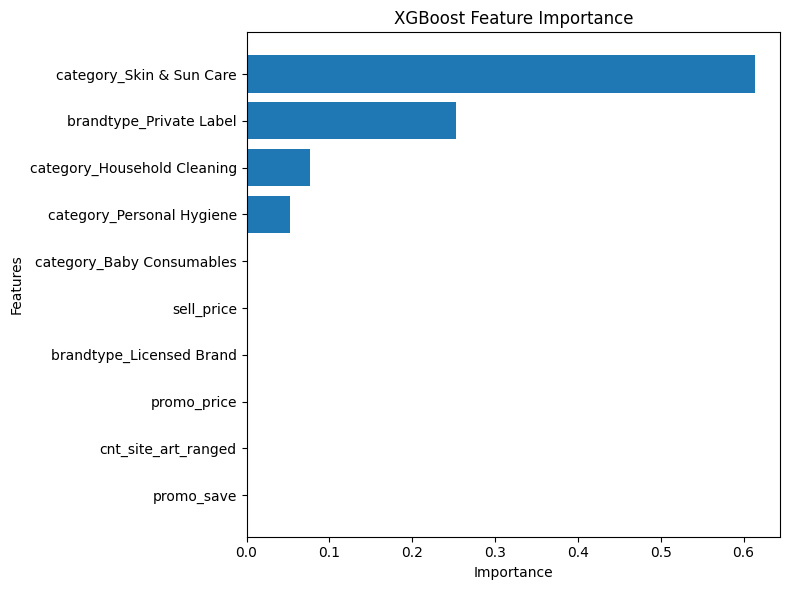

In [34]:
boost = XGBRegressor(objective='reg:squarederror', subsample=0.5,
                     n_estimators=48, max_depth=127, learning_rate=0.05, 
                     random_state=0)

boost.fit(data_model_4.drop(columns='sales_units'), data_model_4['sales_units'])

# Calculate feature importances
features_4 = data_model_4.drop(columns='sales_units').columns
importances_4 = pd.Series(boost.feature_importances_, index=features_4).sort_values()

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(range(len(importances_4[-10:])), importances_4[-10:], tick_label=importances_4.index[-10:])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [35]:
print(importances_4)

brandtype_Manufacturer/National Brand    0.000002
promo_save                               0.000238
cnt_site_art_ranged                      0.000533
promo_price                              0.000809
brandtype_Licensed Brand                 0.000869
sell_price                               0.001163
category_Baby Consumables                0.002074
category_Personal Hygiene                0.052015
category_Household Cleaning              0.076611
brandtype_Private Label                  0.252426
category_Skin & Sun Care                 0.613260
dtype: float32


In [36]:
predictions_4

array([ 9.569443, 20.466942, 30.509224, ..., 13.767899, 16.938644,
       19.981188], dtype=float32)

## Trees

In [37]:
data_model_2 = data.drop(columns=drop_columns)
data_model_test_2 = data_test.drop(columns=drop_columns)

# Apply one-hot encoding
data_model_2 = pd.get_dummies(data_model_2)
data_model_test_2 = pd.get_dummies(data_model_test_2)


parameters_2 = {'max_depth': np.arange(1, 20),
              'min_samples_leaf': np.arange(1, 100)}

random_search_2 = RandomizedSearchCV(DecisionTreeRegressor(criterion='squared_error', random_state=0),
                                   parameters_2, n_iter=20, cv=5,
                                   scoring='neg_mean_squared_error', random_state=0)

model_2 = random_search_2.fit(data_model_2.drop(columns='sales_units'), data_model_2['sales_units'])

print("Best Parameters:", random_search_2.best_params_)

Best Parameters: {'min_samples_leaf': 59, 'max_depth': 17}


#### RMSE

In [38]:
predictions_2 = model_2.predict(data_model_test_2.drop(columns='sales_units'))

print('RMSE: {:.2f}'.format(mse(data_model_test_2['sales_units'], predictions_2, squared=False)))

RMSE: 47.31


In [39]:
from sklearn.tree import export_graphviz
import graphviz

# Define and fit the Decision Tree Regressor
tree = DecisionTreeRegressor(criterion='squared_error', max_depth=17, min_samples_leaf=59, random_state=0)
tree.fit(data_model_2.drop(columns='sales_units'), data_model_2['sales_units'])

# Get feature names
feature_names = data_model_2.drop(columns='sales_units').columns

# Export the decision tree as a Graphviz file
dot_data = export_graphviz(tree, max_depth=3, impurity=False, feature_names=feature_names, rounded=True, filled=True)
graph = graphviz.Source(dot_data)

# Render and save the decision tree visualization
graph.render('tree')

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

## Lasso Regression

In [41]:
data_model, data_model_test = data_model.align(data_model_test, join='left',axis=1, fill_value=0)

Alpha: 0.00
RMSE: 55.56


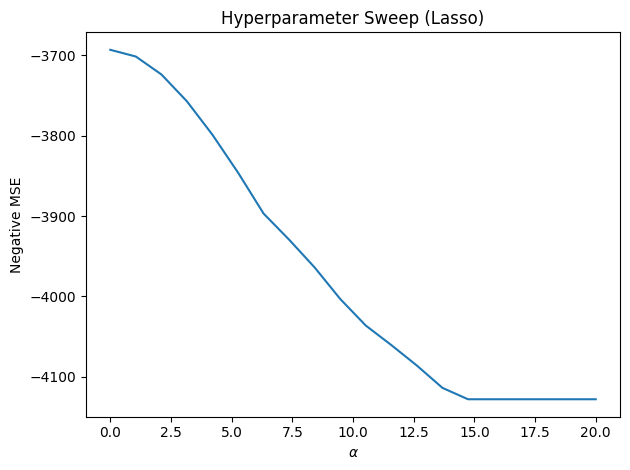

In [42]:
from sklearn.model_selection import cross_val_score

X_train = data_model.drop(columns='sales_units').to_numpy()
y_train = data_model['sales_units'].to_numpy()

X_test = data_model_test.drop(columns='sales_units').to_numpy()
y_test = data_model_test['sales_units'].to_numpy()
# data_model_test = data_model_test[data_model_test['sales_units'] >=0]

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

alphas = np.linspace(0, 20, 20)

neg_mse = []
for alpha in alphas:
    model = Lasso(alpha = alpha)
    scores_mse = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')
    neg_mse.append(scores_mse.mean())

plt.figure()
plt.plot(alphas, neg_mse)
plt.title('Hyperparameter Sweep (Lasso)')
plt.xlabel(r'$\alpha$')
plt.ylabel('Negative MSE')
plt.tight_layout()
# plt.savefig('plot.png', dpi = 200)

best_alpha = alphas[np.argmax(neg_mse)]

final_model = Lasso(alpha = best_alpha)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

print('Alpha: {:.2f}'.format(best_alpha))
print('RMSE: {:.2f}'.format(mse(y_test, y_pred, squared = False)))

## Ridge Regression

Alpha: 20.00
RMSE: 55.56


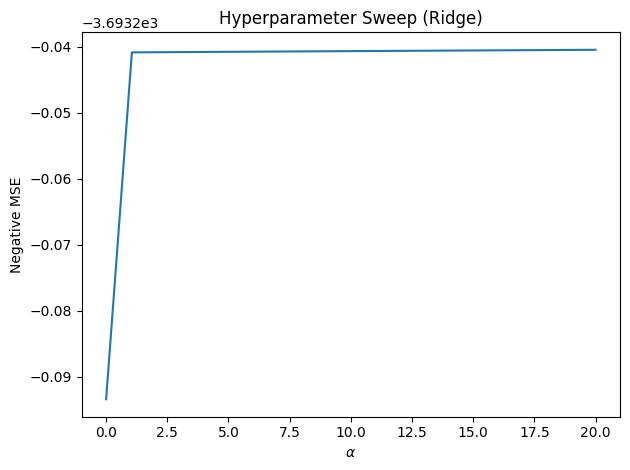

In [43]:
X_train = data_model.drop(columns='sales_units').to_numpy()
y_train = data_model['sales_units'].to_numpy()

X_test = data_model_test.drop(columns='sales_units').to_numpy()
y_test = data_model_test['sales_units'].to_numpy()
# data_model_test = data_model_test[data_model_test['sales_units'] >=0]

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

alphas = np.linspace(0, 20, 20)

neg_mse = []
for alpha in alphas:
    model = Ridge(alpha = alpha)
    scores_mse = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error')
    neg_mse.append(scores_mse.mean())

plt.figure()
plt.plot(alphas, neg_mse)
plt.title('Hyperparameter Sweep (Ridge)')
plt.xlabel(r'$\alpha$')
plt.ylabel('Negative MSE')
plt.tight_layout()
# plt.savefig('plot.png', dpi = 200)

best_alpha = alphas[np.argmax(neg_mse)]

final_model = Ridge(alpha = best_alpha)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

print('Alpha: {:.2f}'.format(best_alpha))
print('RMSE: {:.2f}'.format(mse(y_test, y_pred, squared = False)))
# print('RMSLE: {:.3f}'.format(mean_squared_log_error(data_model_test['sales_units'], y_pred, squared=False)))

## Elastic Net

In [44]:
# Elastic net

X_train = data_model.drop(columns='sales_units').to_numpy()
y_train = data_model['sales_units'].to_numpy()

X_test = data_model_test.drop(columns='sales_units').to_numpy()
y_test = data_model_test['sales_units'].to_numpy()
# data_model_test = data_model_test[data_model_test['sales_units'] >=0]

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

alphas = np.logspace(-4, 0, 100)
ratios = np.linspace(0, 1, 20)
model = ElasticNetCV(alphas = alphas, l1_ratio = ratios, cv = 5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('l1 ratio: {:.2f}'.format(model.l1_ratio_))
print('Alpha: {:.2f}'.format(model.alpha_))
print('RMSE: {:.2f}'.format(mse(y_test, y_pred, squared = False)))
# print('RMSLE: {:.3f}'.format(mean_squared_log_error(data_model_test['sales_units'], y_pred, squared=False)))

l1 ratio: 0.00
Alpha: 0.00
RMSE: 55.56


## OLS 

In [45]:
# OLS
x = data_model.drop(columns=['sales_units'])
y = data_model['sales_units']
# x = sm.add_constant(x)
model_ols = sm.OLS(y, x.astype(float)).fit()


predictions_ols = model_ols.predict(data_model_test.drop(columns='sales_units'))
print(model_ols.summary())
print('RMSE: {:.2f}'.format(mse(data_model_test['sales_units'], predictions_ols.fillna(0), squared = False)))

                            OLS Regression Results                            
Dep. Variable:            sales_units   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                 1.070e+04
Date:                Sat, 04 May 2024   Prob (F-statistic):               0.00
Time:                        18:42:58   Log-Likelihood:            -4.4937e+06
No. Observations:              813247   AIC:                         8.987e+06
Df Residuals:                  813237   BIC:                         8.988e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

## Adding predictions column and COGS

In [46]:
# predictions_4 = np.ceil(predictions_4).astype(int)
predictions = np.ceil(predictions).astype(int)

# # Drop the last 6 columns
# data_test = data_test.iloc[:, :-7]

data_test['COGS'] = data_test['sales_amount'] + data_test['scanback'] - data_test['gross_profit'] 

data_test['cost_unit'] = data_test['COGS'] / data_test['sales_units']

data_test['predicted_units'] = predictions

data_test['predicted_COGS'] = data_test['predicted_units'] * data_test['cost_unit']

data_test['predicted_non_promo_sales_units'] = data_test['predicted_units'] - data_test['promo_units']

data_test['predicted_sales_amount'] = (data_test['predicted_non_promo_sales_units'] * data_test['sell_price'] 
                                       + data_test['promo_units'] * data_test['promo_price'])

data_test['predicted_gross_profit'] = data_test['predicted_sales_amount'] + data_test['scanback'] - data_test['predicted_COGS']

data_test

,calendar_day,article_id,article_desc,category,subcategory,segment,brand,brandtype,sell_price,promo_price,...,tot_soh_ranged_sites,gst_flag,promo_save,COGS,cost_unit,predicted_units,predicted_COGS,predicted_non_promo_sales_units,predicted_sales_amount,predicted_gross_profit
0,2023-05-26,201379,OralB 3DW Freshness Blast Toothpaste 95g,Personal Hygiene,Oral Care,Toothpaste,ORAL B,Manufacturer/National Brand,16.0,16.00,...,1644,Y,0.0000,53.4381,8.906350,8,71.250800,8,128.00,56.749200
1,2023-05-26,198131,Oral B VitalityFlossAction ToothBrush,Personal Hygiene,Oral Care,Power Toothbrushes,ORAL B,Manufacturer/National Brand,50.0,24.13,...,696,Y,0.5174,392.1174,35.647036,15,534.705545,14,724.13,203.044455
2,2023-05-26,198121,Oral B Kids Paste Spiderman 92g,Personal Hygiene,Oral Care,Kids,ORAL B,Manufacturer/National Brand,3.5,3.50,...,2260,Y,0.0000,52.8420,2.201750,31,68.254250,31,108.50,40.245750
3,2023-05-26,197043,COLGATE ADV TEETH WHITENG TPASTE 200G,Personal Hygiene,Oral Care,Toothpaste,COLGATE,Manufacturer/National Brand,10.0,0.01,...,10368,Y,0.9990,329.7718,6.222109,35,217.773830,30,300.05,93.476170
4,2023-05-26,197045,Colgate Adv Whtng Char Tpaste 180g,Personal Hygiene,Oral Care,Toothpaste,COLGATE,Manufacturer/National Brand,10.0,10.00,...,6820,Y,0.0000,263.1669,5.981066,17,101.678120,17,170.00,68.321880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538147,2024-01-11,361965,Olay Regeneris Sup Structre Spf30 50g,Skin & Sun Care,Skincare Face,Olay,OLAY,Manufacturer/National Brand,60.0,60.00,...,1062,Y,0.0000,34.3127,34.312700,2,68.625400,2,120.00,51.374600
538148,2024-01-11,40315,SPASC UNDER- EYE PADS GOLD 4 PAIRS,Skin & Sun Care,Skincare Face,Masks,SPASCRIPTIONS,Manufacturer/National Brand,12.0,12.00,...,1571,Y,0.0000,116.9242,6.153905,12,73.846863,12,144.00,70.153137
538149,2024-01-11,40316,SPASC UNDER- EYE PADS CUCUMBER 4 PAIRS,Skin & Sun Care,Skincare Face,Masks,SPASCRIPTIONS,Manufacturer/National Brand,12.0,12.00,...,1581,Y,0.0000,49.7035,6.212937,12,74.555250,12,144.00,69.444750
538150,2024-01-11,40347,SPASC FACE MASK CHARCOAL GEL W APPLICATR,Skin & Sun Care,Skincare Face,Masks,SPASCRIPTIONS,Manufacturer/National Brand,18.0,18.00,...,1029,Y,0.0000,37.4318,9.357950,15,140.369250,15,270.00,129.630750


In [47]:
# print('RMSE: {:.2f}'.format(mse(data_test['predicted_gross_profit'], predictions_rf, squared = False)))
print('RMSE: {:.2f}'.format(mse(data_test['gross_profit'], data_test['predicted_gross_profit'], squared=False)))

RMSE: 386.16


In [48]:
data_test.isnull().sum()

calendar_day                       0
article_id                         0
article_desc                       0
category                           0
subcategory                        0
segment                            0
brand                              0
brandtype                          0
sell_price                         0
promo_price                        0
promo_sales                        0
promo_units                        0
gross_profit                       0
scanback                           0
sales_amount                       0
sales_units                        0
cnt_site_art_ranged                0
cnt_site_art_ranged_pstv_soh       0
tot_soh_ranged_sites               0
gst_flag                           0
promo_save                         0
COGS                               0
cost_unit                          0
predicted_units                    0
predicted_COGS                     0
predicted_non_promo_sales_units    0
predicted_sales_amount             0
p

In [49]:
print(predictions.sum())
print(len(predictions))

12738564
397038


In [50]:
print(data_test['sales_units'].sum())
print(data_test['sales_units'].count())

12376789
397038


In [51]:
print(data_test['predicted_units'].sum())
print(data_test['predicted_units'].count())

12738564
397038


In [52]:
data_test['predicted_gross_profit'].sum()

45987708.11531125

In [53]:
data_test['gross_profit'].sum()

35824085.563999996